In [10]:
pip install lifelines

In [11]:
pip install scikit-survival

In [12]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from lifelines import LogLogisticAFTFitter, LogNormalAFTFitter, WeibullAFTFitter
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#import eli5
#from eli5.sklearn import PermutationImportance
from scipy import stats
from lifelines.utils import k_fold_cross_validation

%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [13]:
dbcd = pd.read_csv('/content/DBCD.csv')
dbcd

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A4913,A4914,A4915,A4916,A4917,A4918,A4919,A4920,A4921,A4922
0,12.997042,0,1,-0.818530,-0.267032,0.022596,-0.230246,0.198007,-0.509936,0.528540,...,0.000342,-0.148672,0.010020,-0.243390,-0.204327,-0.071979,0.009369,-0.028286,0.619705,-0.393669
1,11.157084,0,1,-0.391394,-0.309574,-0.060363,-0.163607,-0.173488,-0.033876,-0.091487,...,-0.158064,-0.020969,-0.092431,0.170701,-0.293380,-0.125255,-0.051292,0.046259,-0.061444,0.043108
2,10.138080,0,1,-0.624233,-0.119856,-0.235873,-0.174607,0.252850,-0.125016,-0.127058,...,-0.025513,0.292308,-0.116782,0.176038,-0.349162,-0.167774,-0.064431,0.095964,0.167486,0.545882
3,8.802201,0,1,-0.418720,0.161049,-0.329546,-0.023469,0.214949,0.029675,0.040544,...,-0.175852,0.137609,-0.366299,0.005222,-0.185165,0.193407,-0.185198,-0.042248,-0.103990,0.189081
4,10.294064,0,1,-0.810630,-0.536417,-0.211069,-0.200584,0.286504,-0.079759,-0.149976,...,-0.258462,-0.213575,-0.005606,0.091120,-0.104243,-0.161762,0.119698,0.030638,-0.762080,-0.363031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,8.424483,0,1,0.160275,0.228554,-0.300466,0.056553,0.022750,0.554721,0.067238,...,-0.275465,0.258161,0.661894,-0.085457,0.326344,-0.327657,-0.277535,0.168016,-0.087625,-0.040061
291,10.031029,0,1,0.261673,0.399931,-0.031858,0.211332,0.088976,0.404415,0.236193,...,0.045372,-0.415103,0.075576,-0.218558,0.138249,-0.007740,0.210111,-0.007115,1.298576,-0.404783
292,7.378547,0,1,-0.521894,-0.280549,-0.314779,0.132494,-0.213776,0.326215,-0.309374,...,-0.538544,-0.002992,0.206624,-0.022945,-0.107030,-0.443997,0.030036,-0.205376,-0.937327,-0.441240
293,6.754305,0,1,-0.013781,0.241821,0.113072,0.035607,-0.021082,0.276716,0.008162,...,-0.060761,0.047741,-0.033890,0.219354,-0.013937,0.158244,0.215542,0.178013,0.011729,-0.053175


In [14]:
dbcd.keys()

Index(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10',
       ...
       'A4913', 'A4914', 'A4915', 'A4916', 'A4917', 'A4918', 'A4919', 'A4920',
       'A4921', 'A4922'],
      dtype='object', length=4922)

In [15]:
dbcd_X = dbcd.copy()
del dbcd_X['A3']
del dbcd_X['A1']
del dbcd_X['A2']
dbcd_X

,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,...,A4913,A4914,A4915,A4916,A4917,A4918,A4919,A4920,A4921,A4922
0,-0.818530,-0.267032,0.022596,-0.230246,0.198007,-0.509936,0.528540,0.353889,-0.261211,0.012211,...,0.000342,-0.148672,0.010020,-0.243390,-0.204327,-0.071979,0.009369,-0.028286,0.619705,-0.393669
1,-0.391394,-0.309574,-0.060363,-0.163607,-0.173488,-0.033876,-0.091487,0.036426,0.346306,0.006689,...,-0.158064,-0.020969,-0.092431,0.170701,-0.293380,-0.125255,-0.051292,0.046259,-0.061444,0.043108
2,-0.624233,-0.119856,-0.235873,-0.174607,0.252850,-0.125016,-0.127058,-0.019610,0.047369,-0.150373,...,-0.025513,0.292308,-0.116782,0.176038,-0.349162,-0.167774,-0.064431,0.095964,0.167486,0.545882
3,-0.418720,0.161049,-0.329546,-0.023469,0.214949,0.029675,0.040544,0.040263,-0.125128,-0.182503,...,-0.175852,0.137609,-0.366299,0.005222,-0.185165,0.193407,-0.185198,-0.042248,-0.103990,0.189081
4,-0.810630,-0.536417,-0.211069,-0.200584,0.286504,-0.079759,-0.149976,0.045348,-0.109650,-0.071952,...,-0.258462,-0.213575,-0.005606,0.091120,-0.104243,-0.161762,0.119698,0.030638,-0.762080,-0.363031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,0.160275,0.228554,-0.300466,0.056553,0.022750,0.554721,0.067238,0.228643,-0.576229,-0.159748,...,-0.275465,0.258161,0.661894,-0.085457,0.326344,-0.327657,-0.277535,0.168016,-0.087625,-0.040061
291,0.261673,0.399931,-0.031858,0.211332,0.088976,0.404415,0.236193,0.332496,-0.019071,0.318344,...,0.045372,-0.415103,0.075576,-0.218558,0.138249,-0.007740,0.210111,-0.007115,1.298576,-0.404783
292,-0.521894,-0.280549,-0.314779,0.132494,-0.213776,0.326215,-0.309374,-0.080955,-0.256351,-0.192468,...,-0.538544,-0.002992,0.206624,-0.022945,-0.107030,-0.443997,0.030036,-0.205376,-0.937327,-0.441240
293,-0.013781,0.241821,0.113072,0.035607,-0.021082,0.276716,0.008162,-0.025968,-0.018023,-0.020874,...,-0.060761,0.047741,-0.033890,0.219354,-0.013937,0.158244,0.215542,0.178013,0.011729,-0.053175


#PCA

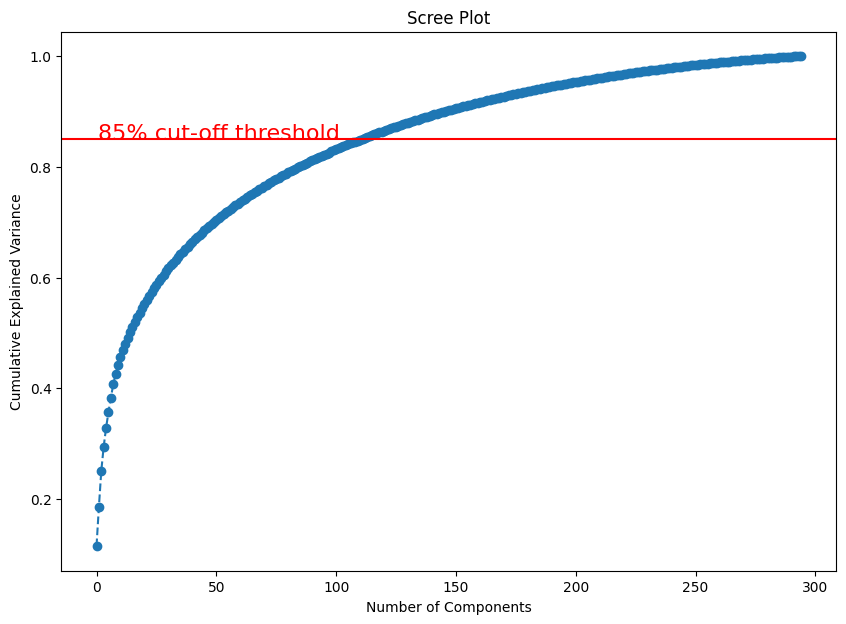

Eigenvalues > 1: 294
Number of Components explaining 85% variance is 112


In [16]:
# Fit PCA
scaler = StandardScaler()
dbcd_standard = scaler.fit_transform(dbcd_X)
pca = PCA().fit(dbcd_standard)

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Scree plot
plt.figure(figsize=(10, 7))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.axhline(y=0.85, color='r', linestyle='-')
plt.text(0.5, 0.85, '85% cut-off threshold', color = 'red', fontsize=16)
plt.show()

# Eigenvalue > 1 (Kaiser Criterion)
eigenvalues = pca.explained_variance_
print("Eigenvalues > 1:", np.sum(eigenvalues > 1))

# Cumulative Explained Variance
cumulative_variance = np.cumsum(explained_variance)
print("Number of Components explaining 85% variance is", np.argmax(cumulative_variance >= 0.85) + 1)

In [39]:
pca = PCA(n_components=10)
feat_pca = pca.fit_transform(dbcd_standard)
name_pca = ["X_"+str(i) for i in range(feat_pca.shape[1])]
dbcd_pca = pd.DataFrame(data = feat_pca, columns=name_pca)
dbcd_pca['time'] = dbcd['A1']
dbcd_pca['status'] = dbcd['A2']
dbcd_pca

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,time,status
0,-13.666800,-16.801074,-26.115334,6.449698,22.824940,-4.956835,-1.928435,10.838909,0.639433,17.430707,12.997042,0
1,35.061998,-14.039049,6.210023,7.182232,-11.312532,-3.543811,9.731610,-1.969365,4.627732,17.824477,11.157084,0
2,19.267993,11.740367,26.488734,-10.896498,-2.589102,-6.169435,0.053784,-3.061657,7.712593,17.463752,10.138080,0
3,16.017840,17.389991,4.169360,14.647068,23.509273,-20.383655,-8.811160,-4.331628,7.345643,-1.560273,8.802201,0
4,8.148621,-26.129363,24.801178,-11.700470,14.225550,-8.664514,-7.075010,-11.437308,-5.035781,18.601967,10.294064,0
...,...,...,...,...,...,...,...,...,...,...,...,...
290,-49.115999,-12.538706,21.585474,0.070724,2.829857,-7.727398,-4.835524,-6.009174,-6.074764,-0.601331,8.424483,0
291,11.357767,-68.694583,23.138200,-3.845882,11.597981,-29.852546,-7.252092,-10.570651,-13.586885,-10.962303,10.031029,0
292,-31.054423,-18.111144,13.650744,-0.693158,-2.343796,-12.004557,-9.956755,-6.462619,-6.443694,-4.441430,7.378547,0
293,18.459357,-31.984888,27.336616,26.587724,13.173072,-12.857651,-5.667544,-4.841478,-5.491489,8.300058,6.754305,0


In [44]:
X_train, X_test, E_train, E_test, Y_train, Y_test = train_test_split(dbcd_pca[name_pca], dbcd_pca['status'], dbcd_pca['time'], test_size=0.25, random_state=6)
aft_weibull_imp = WeibullAFTFitter()
aft_weibull_imp.fit(pd.concat([X_train, E_train, Y_train], axis=1), duration_col='time', event_col='status', robust=True)
aft_weibull_imp.print_summary()
print("C-Index for testing= ", aft_weibull_imp.score(pd.concat([X_test, E_test, Y_test], axis=1), scoring_method="concordance_index"))

<lifelines.WeibullAFTFitter: fitted with 221 total observations, 161 right-censored observations>
             duration col = 'time'
                event col = 'status'
          robust variance = True
   number of observations = 221
number of events observed = 60
           log-likelihood = -231.63
         time fit was run = 2024-07-14 09:26:38 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                  
lambda_ X_0        0.03      1.03      0.01            0.02            0.04                1.02                1.04
        X_1       -0.00      1.00      0.01           -0.01            0.01                0.99                1.01
        X_2        0.00      1.00      0.01           -0.01            0.01                0.99                1.01
        X_3        0.01      1.01      0.01           -0.00            0.02                1.00                1.02
        X_4        0.02      1.02      0.01           -0.00            0.03                1.00                1.03
        X_5       -0.04      0.96      0.01           -0.06           -0.02                0.94                0.98
        X_6        0.02      1.02      0.01           -0.01            0.04                0.99                1.04
        X_7        0.02      1.02      0.01           -0.01            0.04                0.99                1.04
        X_8       -0.00      1.00      0.01           -0.03            0.02                0.97                1.02
        X_9        0.02      1.02      0.01           -0.01            0.04                0.99                1.04
        Intercept  3.34     28.22      0.17            3.01            3.67               20.33               39.16
rho_    Intercept  0.25      1.29      0.07            0.12            0.39                1.12                1.47

                   cmp to     z      p  -log2(p)
param   covariate                               
lambda_ X_0          0.00  5.39 <0.005     23.76
        X_1          0.00 -0.12   0.90      0.15
        X_2          0.00  0.47   0.64      0.65
        X_3          0.00  1.60   0.11      3.18
        X_4          0.00  1.93   0.05      4.23
        X_5          0.00 -3.90 <0.005     13.36
        X_6          0.00  1.44   0.15      2.73
        X_7          0.00  1.45   0.15      2.76
        X_8          0.00 -0.43   0.67      0.58
        X_9          0.00  1.17   0.24      2.05
        Intercept    0.00 19.98 <0.005    292.57
rho_    Intercept    0.00  3.65 <0.005     11.92
---
Concordance = 0.76
AIC = 487.26
log-likelihood ratio test = 56.44 on 10 df
-log2(p) of ll-ratio test = 25.81

C-Index for testing=  0.7845691382765531


In [45]:
aft_loglogistic_imp = LogLogisticAFTFitter()
aft_loglogistic_imp.fit(pd.concat([X_train, E_train, Y_train], axis=1), duration_col='time', event_col='status', robust=True)
aft_loglogistic_imp.print_summary()
print("C-Index for testing= ", aft_loglogistic_imp.score(pd.concat([X_test, E_test, Y_test], axis=1), scoring_method="concordance_index"))

<lifelines.LogLogisticAFTFitter: fitted with 221 total observations, 161 right-censored observations>
             duration col = 'time'
                event col = 'status'
          robust variance = True
   number of observations = 221
number of events observed = 60
           log-likelihood = -229.05
         time fit was run = 2024-07-14 09:26:53 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                  
alpha_ X_0        0.03      1.03      0.00            0.02            0.04                1.02                1.04
       X_1        0.00      1.00      0.01           -0.01            0.01                0.99                1.01
       X_2        0.00      1.00      0.01           -0.01            0.02                0.99                1.02
       X_3        0.01      1.01      0.01           -0.00            0.03                1.00                1.03
       X_4        0.01      1.01      0.01           -0.00            0.03                1.00                1.03
       X_5       -0.04      0.96      0.01           -0.06           -0.02                0.94                0.98
       X_6        0.01      1.01      0.01           -0.01            0.04                0.99                1.04
       X_7        0.02      1.02      0.01           -0.00            0.04                1.00                1.04
       X_8       -0.01      0.99      0.01           -0.03            0.02                0.97                1.02
       X_9        0.01      1.01      0.01           -0.01            0.04                0.99                1.04
       Intercept  2.97     19.55      0.16            2.66            3.29               14.25               26.81
beta_  Intercept  0.46      1.58      0.08            0.30            0.62                1.35                1.85

                  cmp to     z      p  -log2(p)
param  covariate                               
alpha_ X_0          0.00  6.12 <0.005     29.95
       X_1          0.00  0.26   0.79      0.34
       X_2          0.00  0.65   0.52      0.95
       X_3          0.00  1.74   0.08      3.62
       X_4          0.00  1.64   0.10      3.30
       X_5          0.00 -3.75 <0.005     12.49
       X_6          0.00  1.12   0.26      1.92
       X_7          0.00  1.63   0.10      3.28
       X_8          0.00 -0.60   0.55      0.86
       X_9          0.00  1.00   0.32      1.65
       Intercept    0.00 18.44 <0.005    249.88
beta_  Intercept    0.00  5.72 <0.005     26.46
---
Concordance = 0.77
AIC = 482.10
log-likelihood ratio test = 57.83 on 10 df
-log2(p) of ll-ratio test = 26.68

C-Index for testing=  0.7855711422845691


In [46]:
aft_lognormal_imp = LogNormalAFTFitter()
aft_lognormal_imp.fit(pd.concat([X_train, E_train, Y_train], axis=1), duration_col='time', event_col='status', robust=True)
aft_lognormal_imp.print_summary()
print("C-Index for testing= ", aft_lognormal_imp.score(pd.concat([X_test, E_test, Y_test], axis=1), scoring_method="concordance_index"))

<lifelines.LogNormalAFTFitter: fitted with 221 total observations, 161 right-censored observations>
             duration col = 'time'
                event col = 'status'
          robust variance = True
   number of observations = 221
number of events observed = 60
           log-likelihood = -226.97
         time fit was run = 2024-07-14 09:27:05 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                  
mu_    X_0        0.03      1.03      0.00            0.02            0.03                1.02                1.03
       X_1        0.00      1.00      0.01           -0.01            0.01                0.99                1.01
       X_2        0.00      1.00      0.01           -0.01            0.01                0.99                1.01
       X_3        0.01      1.01      0.01           -0.00            0.03                1.00                1.03
       X_4        0.01      1.01      0.01           -0.00            0.03                1.00                1.03
       X_5       -0.03      0.97      0.01           -0.05           -0.02                0.95                0.98
       X_6        0.01      1.01      0.01           -0.01            0.03                0.99                1.03
       X_7        0.02      1.02      0.01           -0.00            0.04                1.00                1.04
       X_8       -0.01      0.99      0.01           -0.03            0.01                0.97                1.01
       X_9        0.01      1.01      0.01           -0.01            0.04                0.99                1.04
       Intercept  2.96     19.30      0.15            2.66            3.26               14.31               26.03
sigma_ Intercept  0.09      1.09      0.08           -0.07            0.24                0.93                1.28

                  cmp to     z      p  -log2(p)
param  covariate                               
mu_    X_0          0.00  6.69 <0.005     35.40
       X_1          0.00  0.24   0.81      0.30
       X_2          0.00  0.45   0.65      0.62
       X_3          0.00  1.78   0.07      3.74
       X_4          0.00  1.61   0.11      3.23
       X_5          0.00 -3.70 <0.005     12.18
       X_6          0.00  1.09   0.27      1.86
       X_7          0.00  1.92   0.05      4.19
       X_8          0.00 -1.03   0.30      1.72
       X_9          0.00  1.14   0.26      1.97
       Intercept    0.00 19.40 <0.005    275.96
sigma_ Intercept    0.00  1.10   0.27      1.87
---
Concordance = 0.77
AIC = 477.93
log-likelihood ratio test = 55.88 on 10 df
-log2(p) of ll-ratio test = 25.46

C-Index for testing=  0.7935871743486974


In [47]:
#Buat label RSF
dt = [('cens', '?'), ('time', '<f8')]
Y_ = []
for i, a in enumerate(dbcd_pca['time']):
  if dbcd_pca['status'][i]==1:
    Y_.append((True, a))
  else:
    Y_.append((False, a))

Y_ar = np. array(Y_, dtype=dt)
Y_ar

array([(False, 12.9970417), (False, 11.1570836), (False, 10.1380805),
       (False,  8.8022009), (False, 10.2940645), (False,  5.8042112),
       (False,  7.8576216), (False,  8.1670909), (False,  8.2327145),
       (False,  7.8658207), (False,  6.9706851), (False,  5.1855713),
       (False,  6.245008 ), (False, 11.3890819), (False, 10.1080349),
       (False,  7.3539163), (False, 11.017054 ), (False,  4.7315923),
       ( True,  2.1726437), ( True,  9.526054 ), ( True,  8.4658698),
       ( True,  5.1508002), ( True,  5.3562837), (False,  4.9946889),
       ( True,  7.928802 ), (False,  4.1178098), ( True,  2.7096374),
       ( True,  2.6083967), ( True,  5.504162 ), ( True,  2.619267 ),
       ( True,  2.2905456), ( True,  3.7370838), ( True,  5.7796823),
       ( True,  3.4552542), (False,  3.2252092), (False,  2.3107295),
       ( True,  3.2526602), ( True,  3.2416183), (False,  5.3032733),
       (False,  5.2320549), (False, 10.0970156), (False, 14.8170925),
       (False, 14.26

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(dbcd_pca[name_pca], Y_ar, test_size=0.25, random_state=6)
rsf_dbcd1 = RandomSurvivalForest(n_estimators=70,
                           min_samples_split=3,
                           min_samples_leaf=10,
                           max_features="sqrt",
                           n_jobs=-1, random_state=1)
rsf_dbcd1.fit(X_train, Y_train)
c_rsf1 = rsf_dbcd1.score(X_test, Y_test)
print("C-Index = ", c_rsf1)

C-Index =  0.7805611222444889


# Factor Analysis

In [50]:
FA = FactorAnalysis(n_components=15, random_state=0)
feat_fa = FA.fit_transform(dbcd_standard)
name_fa = ["X_"+str(i) for i in range(feat_fa.shape[1])]
dbcd_fa = pd.DataFrame(data = feat_fa, columns=name_fa)
dbcd_fa['time'] = dbcd['A1']
dbcd_fa['status'] = dbcd['A2']
dbcd_fa

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,time,status
0,0.935716,-1.235765,-1.007166,0.104901,-1.895911,0.073013,0.509692,-1.062185,0.326966,-1.351374,-0.705871,1.938396,-2.518501,-0.480328,0.111400,12.997042,0
1,-1.504205,-0.745094,0.582867,0.527701,0.284889,-0.314183,-0.845153,0.388634,0.180644,-1.413007,-1.664536,0.942764,-1.157385,0.567318,-1.176685,11.157084,0
2,-0.991716,1.210255,0.989063,-0.593806,0.074332,0.309685,-0.751204,0.201126,0.679681,-1.787438,-0.142066,1.125698,-0.142648,-0.680798,-1.033691,10.138080,0
3,-0.625276,0.710825,-0.643376,0.753339,-1.785405,1.999848,-0.524745,-0.033019,0.618796,-0.249580,-0.411971,-1.606853,0.367534,0.134175,0.090114,8.802201,0
4,-0.302283,-0.284915,1.793538,-0.830840,-1.314895,0.923817,0.465976,0.342885,-0.707833,-2.207538,-0.823484,0.067119,-0.569018,-0.630420,-0.698952,10.294064,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,1.967582,0.109527,1.468278,0.037720,-0.181401,1.053973,0.025539,0.098136,-0.701394,0.169898,-0.297698,0.233908,0.016519,1.502457,-0.190803,8.424483,0
291,-0.469454,-2.705701,2.529046,-0.885229,-1.338282,2.290224,-0.697021,-0.439825,-2.020973,0.924540,2.901812,2.443243,0.067700,-0.657057,-0.312006,10.031029,0
292,1.155447,-0.560918,1.154606,-0.259994,0.431367,1.500003,0.014963,-0.089644,-0.596382,-0.046870,1.627826,-0.113263,-0.341837,1.891320,-3.053339,7.378547,0
293,-0.881770,-0.881076,1.696951,1.614524,-1.386663,1.371724,0.059891,-0.177300,-0.923983,-1.200451,0.601276,0.180946,-0.690075,-0.131365,0.527899,6.754305,0


In [51]:
X_train, X_test, E_train, E_test, Y_train, Y_test = train_test_split(dbcd_fa[name_fa], dbcd_fa['status'], dbcd_fa['time'], test_size=0.25, random_state=6)
aft_weibull_imp = WeibullAFTFitter()
aft_weibull_imp.fit(pd.concat([X_train, E_train, Y_train], axis=1), duration_col='time', event_col='status', robust=True)
aft_weibull_imp.print_summary()
print("C-Index for testing= ", aft_weibull_imp.score(pd.concat([X_test, E_test, Y_test], axis=1), scoring_method="concordance_index"))

<lifelines.WeibullAFTFitter: fitted with 221 total observations, 161 right-censored observations>
             duration col = 'time'
                event col = 'status'
          robust variance = True
   number of observations = 221
number of events observed = 60
           log-likelihood = -228.07
         time fit was run = 2024-07-14 09:27:41 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                  
lambda_ X_0       -0.63      0.53      0.12           -0.87           -0.39                0.42                0.68
        X_1       -0.11      0.90      0.12           -0.34            0.13                0.71                1.14
        X_10       0.10      1.11      0.15           -0.19            0.40                0.82                1.49
        X_11       0.20      1.22      0.13           -0.06            0.45                0.95                1.57
        X_12      -0.11      0.90      0.09           -0.29            0.08                0.75                1.08
        X_13      -0.06      0.94      0.12           -0.29            0.17                0.75                1.19
        X_14      -0.01      0.99      0.12           -0.24            0.23                0.79                1.26
        X_2       -0.01      0.99      0.13           -0.26            0.24                0.77                1.28
        X_3        0.08      1.08      0.11           -0.14            0.30                0.87                1.35
        X_4       -0.43      0.65      0.11           -0.65           -0.21                0.52                0.81
        X_5        0.16      1.17      0.14           -0.11            0.43                0.90                1.53
        X_6       -0.43      0.65      0.15           -0.73           -0.13                0.48                0.88
        X_7       -0.25      0.78      0.13           -0.50            0.00                0.61                1.00
        X_8       -0.18      0.83      0.12           -0.42            0.06                0.66                1.06
        X_9       -0.12      0.89      0.11           -0.33            0.09                0.72                1.10
        Intercept  3.38     29.46      0.17            3.04            3.72               21.00               41.34
rho_    Intercept  0.26      1.29      0.07            0.12            0.40                1.13                1.49

                   cmp to     z      p  -log2(p)
param   covariate                               
lambda_ X_0          0.00 -5.09 <0.005     21.39
        X_1          0.00 -0.88   0.38      1.41
        X_10         0.00  0.67   0.50      0.99
        X_11         0.00  1.53   0.13      2.98
        X_12         0.00 -1.14   0.25      1.98
        X_13         0.00 -0.50   0.62      0.69
        X_14         0.00 -0.05   0.96      0.05
        X_2          0.00 -0.06   0.95      0.07
        X_3          0.00  0.73   0.47      1.10
        X_4          0.00 -3.83 <0.005     12.95
        X_5          0.00  1.17   0.24      2.04
        X_6          0.00 -2.81 <0.005      7.66
        X_7          0.00 -1.92   0.05      4.19
        X_8          0.00 -1.50   0.13      2.91
        X_9          0.00 -1.12   0.26      1.92
        Intercept    0.00 19.58 <0.005    281.18
rho_    Intercept    0.00  3.66 <0.005     11.97
---
Concordance = 0.78
AIC = 490.13
log-likelihood ratio test = 63.57 on 15 df
-log2(p) of ll-ratio test = 23.97

C-Index for testing=  0.7805611222444889


In [52]:
aft_loglogistic_imp = LogLogisticAFTFitter()
aft_loglogistic_imp.fit(pd.concat([X_train, E_train, Y_train], axis=1), duration_col='time', event_col='status', robust=True)
aft_loglogistic_imp.print_summary()
print("C-Index for testing= ", aft_loglogistic_imp.score(pd.concat([X_test, E_test, Y_test], axis=1), scoring_method="concordance_index"))

<lifelines.LogLogisticAFTFitter: fitted with 221 total observations, 161 right-censored observations>
             duration col = 'time'
                event col = 'status'
          robust variance = True
   number of observations = 221
number of events observed = 60
           log-likelihood = -223.44
         time fit was run = 2024-07-14 09:27:54 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                  
alpha_ X_0       -0.64      0.53      0.11           -0.85           -0.43                0.43                0.65
       X_1       -0.05      0.95      0.12           -0.28            0.19                0.75                1.21
       X_10       0.12      1.13      0.14           -0.15            0.39                0.86                1.48
       X_11       0.28      1.32      0.13            0.01            0.54                1.01                1.71
       X_12      -0.13      0.88      0.10           -0.32            0.06                0.72                1.06
       X_13      -0.08      0.93      0.10           -0.27            0.12                0.76                1.13
       X_14       0.05      1.05      0.12           -0.18            0.27                0.83                1.31
       X_2        0.02      1.02      0.13           -0.24            0.27                0.79                1.31
       X_3        0.12      1.13      0.11           -0.10            0.34                0.91                1.41
       X_4       -0.39      0.67      0.10           -0.60           -0.19                0.55                0.83
       X_5        0.16      1.18      0.14           -0.12            0.45                0.89                1.56
       X_6       -0.35      0.70      0.15           -0.64           -0.06                0.53                0.94
       X_7       -0.30      0.74      0.12           -0.53           -0.07                0.59                0.93
       X_8       -0.20      0.82      0.12           -0.43            0.04                0.65                1.04
       X_9       -0.13      0.88      0.12           -0.36            0.10                0.70                1.11
       Intercept  2.99     19.81      0.16            2.67            3.31               14.37               27.30
beta_  Intercept  0.51      1.67      0.09            0.34            0.68                1.40                1.98

                  cmp to     z      p  -log2(p)
param  covariate                               
alpha_ X_0          0.00 -5.85 <0.005     27.59
       X_1          0.00 -0.39   0.69      0.53
       X_10         0.00  0.86   0.39      1.35
       X_11         0.00  2.04   0.04      4.60
       X_12         0.00 -1.32   0.19      2.43
       X_13         0.00 -0.76   0.45      1.16
       X_14         0.00  0.39   0.70      0.52
       X_2          0.00  0.13   0.90      0.15
       X_3          0.00  1.09   0.27      1.87
       X_4          0.00 -3.76 <0.005     12.54
       X_5          0.00  1.12   0.26      1.92
       X_6          0.00 -2.40   0.02      5.92
       X_7          0.00 -2.55   0.01      6.56
       X_8          0.00 -1.65   0.10      3.33
       X_9          0.00 -1.09   0.28      1.85
       Intercept    0.00 18.24 <0.005    244.48
beta_  Intercept    0.00  5.84 <0.005     27.55
---
Concordance = 0.79
AIC = 480.88
log-likelihood ratio test = 69.04 on 15 df
-log2(p) of ll-ratio test = 27.17

C-Index for testing=  0.782565130260521


In [53]:
aft_lognormal_imp = LogNormalAFTFitter()
aft_lognormal_imp.fit(pd.concat([X_train, E_train, Y_train], axis=1), duration_col='time', event_col='status', robust=True)
aft_lognormal_imp.print_summary()
print("C-Index for testing= ", aft_lognormal_imp.score(pd.concat([X_test, E_test, Y_test], axis=1), scoring_method="concordance_index"))

<lifelines.LogNormalAFTFitter: fitted with 221 total observations, 161 right-censored observations>
             duration col = 'time'
                event col = 'status'
          robust variance = True
   number of observations = 221
number of events observed = 60
           log-likelihood = -221.41
         time fit was run = 2024-07-14 09:28:08 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                  
mu_    X_0       -0.61      0.54      0.09           -0.80           -0.43                0.45                0.65
       X_1       -0.05      0.95      0.11           -0.26            0.15                0.77                1.17
       X_10       0.09      1.09      0.11           -0.14            0.31                0.87                1.36
       X_11       0.25      1.28      0.11            0.02            0.47                1.02                1.60
       X_12      -0.13      0.87      0.09           -0.31            0.04                0.73                1.04
       X_13      -0.10      0.90      0.09           -0.28            0.07                0.76                1.07
       X_14       0.05      1.05      0.10           -0.14            0.23                0.87                1.26
       X_2       -0.00      1.00      0.11           -0.22            0.22                0.80                1.24
       X_3        0.11      1.12      0.11           -0.09            0.32                0.91                1.37
       X_4       -0.36      0.70      0.09           -0.54           -0.17                0.58                0.84
       X_5        0.13      1.14      0.12           -0.12            0.37                0.89                1.45
       X_6       -0.32      0.73      0.12           -0.55           -0.08                0.58                0.92
       X_7       -0.30      0.74      0.10           -0.50           -0.10                0.61                0.91
       X_8       -0.20      0.82      0.10           -0.39           -0.01                0.68                0.99
       X_9       -0.12      0.89      0.10           -0.31            0.07                0.73                1.08
       Intercept  2.98     19.72      0.15            2.68            3.28               14.60               26.63
sigma_ Intercept  0.04      1.04      0.08           -0.13            0.20                0.88                1.23

                  cmp to     z      p  -log2(p)
param  covariate                               
mu_    X_0          0.00 -6.47 <0.005     33.25
       X_1          0.00 -0.50   0.61      0.70
       X_10         0.00  0.76   0.45      1.16
       X_11         0.00  2.16   0.03      5.02
       X_12         0.00 -1.50   0.13      2.91
       X_13         0.00 -1.17   0.24      2.04
       X_14         0.00  0.47   0.64      0.65
       X_2          0.00 -0.01   1.00      0.01
       X_3          0.00  1.07   0.29      1.80
       X_4          0.00 -3.74 <0.005     12.43
       X_5          0.00  1.02   0.31      1.71
       X_6          0.00 -2.65   0.01      6.97
       X_7          0.00 -2.93 <0.005      8.20
       X_8          0.00 -2.05   0.04      4.63
       X_9          0.00 -1.22   0.22      2.18
       Intercept    0.00 19.46 <0.005    277.77
sigma_ Intercept    0.00  0.46   0.65      0.63
---
Concordance = 0.79
AIC = 476.82
log-likelihood ratio test = 66.99 on 15 df
-log2(p) of ll-ratio test = 25.97

C-Index for testing=  0.7805611222444889


In [54]:
X_train, X_test, Y_train, Y_test = train_test_split(dbcd_fa[name_fa], Y_ar, test_size=0.25, random_state=6)
rsf_dbcd2 = RandomSurvivalForest(n_estimators=70,
                           min_samples_split=3,
                           min_samples_leaf=10,
                           max_features="sqrt",
                           n_jobs=-1, random_state=1)
rsf_dbcd2.fit(X_train, Y_train)
c_rsf2 = rsf_dbcd2.score(X_test, Y_test)
print("C-Index = ", c_rsf2)

C-Index =  0.7995991983967936
